In [231]:
# import libraries we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import datetime # manipulating date formats

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split


%matplotlib inline

# import datasets
df_train = pd.read_csv('data/train.csv', low_memory=False,parse_dates = True)
df_test = pd.read_csv('data/test.csv', low_memory=False,parse_dates = True)
df_store = pd.read_csv('data/store.csv', low_memory=False,parse_dates = True)
df_sample_submission = pd.read_csv('data/sample_submission.csv')

In [232]:
# Let's build a function to count if the categorical and numerical columns of the dataset
def cat_or_num(df):
    '''
    Function that clasifies the kind of columns (categorical or numerical) that exist in a dataset
    Input:  
            df: dataset where we want to clasify columns
    Output: 
            num_cols,cat:cols: it returns a dictionary with the category of every column
    
    '''   
    cat_cols = []
    num_cols = []

    num_cols =[i for i in df.columns if df.dtypes[i]!='object']
    cat_cols =[i for i in df.columns if df.dtypes[i]=='object']
            
    return cat_cols, num_cols

In [233]:
# get information about the cols and features
def show_cols_info(df):
    '''
    Function that shows the summary of the information of the columns of the datasets
    Input:  
            df: dataset we want to show information 
    Output: 
            none: it prints a summary and the main values of every column
    
    '''     

    for column in df.columns:
        # show a summary of the important information of the column
        df.describe([column]).show()
        # show the different values of the field
        df.select([column]).distinct().show()

# Let's start our EDA phase

In [234]:
print("*************************************** STORE ***************************************")
df_store.info()
print("*************************************** TRAIN ***************************************")
df_train.info()
print("*************************************** TEST ***************************************")
df_test.info()

*************************************** STORE ***************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB
*************************************** TRAIN **************************

In [235]:
len(df_train), len(df_test)

(1017209, 41088)

# First we'll analyse the store dataset

In [236]:
# First we'll see the store dataset
df_store.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [237]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


* Store: There are 1115 stores
* There are some nulls values in this dataset
* There are 4 types of store a,b,c,d
* There are 3 types of assortment a,b,c
* CompetitionDistance: distance in meters to the next competitor store
* CompetitionOpenSinceMonth: the months when the competitor opened
* Promo2 is a promotion, 0 there is a promotion, 1 there is no promotion
* Promo2Since, the time when the store started to participate in a Promo2
* PromoInterval: the interval for the promotion period

In [238]:
# There are 1115 different Stores
len(df_store['Store'].unique())

1115

In [239]:
df_store.Store.describe()

count    1115.00000
mean      558.00000
std       322.01708
min         1.00000
25%       279.50000
50%       558.00000
75%       836.50000
max      1115.00000
Name: Store, dtype: float64

In [240]:
# There are 4 types of store a,b,c,d
df_store.StoreType.unique()

array(['c', 'a', 'd', 'b'], dtype=object)

In [358]:
mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
df_store.StoreType.replace(mappings, inplace=True)

In [241]:
# There are 3 types of assortment a,b,c
df_store.Assortment.unique()

array(['a', 'c', 'b'], dtype=object)

In [359]:
df_store.Assortment.replace(mappings, inplace=True)

In [242]:
len(df_store.CompetitionDistance.unique())

655

In [243]:
len(df_store.CompetitionOpenSinceMonth.unique())

13

In [244]:
len(df_store.CompetitionOpenSinceYear.unique())

24

In [245]:
len(df_store.Promo2.unique())

2

In [246]:
len(df_store.Promo2SinceWeek.unique())

25

In [247]:
len(df_store.Promo2SinceYear.unique())

8

In [248]:
len(df_store.PromoInterval.unique())

4

In [360]:
df_store.head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,1,1,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,1,1,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,3,3,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,1,1,29910.0,4.0,2015.0,0,0.0,0.0,0


<AxesSubplot:>

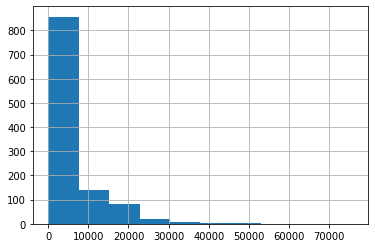

In [361]:
df_store.CompetitionDistance.hist()

<AxesSubplot:>

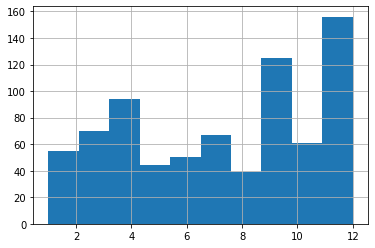

In [251]:
df_store.CompetitionOpenSinceMonth.hist()

In [252]:
df_store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [362]:
# Let's deal with null values ... starting with CompetitionDistance
df_store[pd.isnull(df_store.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval


In [363]:
# Let's impute with median values
df_store['CompetitionDistance'].fillna(df_store['CompetitionDistance'].median(),inplace=True)

In [364]:
df_store.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [365]:
# If there is 0 CompetitionDistance, it seems congruent that the CompetitionOpenSinceMonth and 
# CompetitionOpenSinceYear is null
# So let's impute with 0
df_store['CompetitionOpenSinceMonth'].fillna(0,inplace=True)
df_store['CompetitionOpenSinceYear'].fillna(0,inplace=True)

In [366]:
df_store.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [367]:
# Let's select the nulls in Promo2SinceWeek and see if there are Promo2
aux = df_store[pd.isnull(df_store.Promo2SinceWeek)]
len(aux[aux.Promo2==0])

0

In [368]:
# We can see that if there is no Promo2, the Promo2SinceWeek is null
# Let's impute with 0

df_store['Promo2SinceWeek'].fillna(0,inplace=True)
df_store['Promo2SinceYear'].fillna(0,inplace=True)
df_store['PromoInterval'].fillna(0,inplace=True)

In [369]:
# Then we don't have any null values in df_store dataset!
df_store.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

#Let's see train dataset

In [370]:
# There are 7 columns: Store, DayOfWeek, Sales, Customers, Open, Promo, ShoolHoliday
df_train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,Week,is_quarter_start,is_quarter_end,is_month_start,is_month_end,is_year_start,is_year_end,SalesbyCustomer
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,3.052470e-02,1.786467e-01,2.013832e+03,5.846762e+00,1.570279e+01,2.361551e+01,1.170261e-02,1.060746e-02,3.291752e-02,3.291851e-02,3.287427e-03,2.015318e-03,7.880231e+00
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,1.720261e-01,3.830564e-01,7.773960e-01,3.326097e+00,8.787638e+00,1.443338e+01,1.075438e-01,1.024449e-01,1.784208e-01,1.784234e-01,5.724179e-02,4.484706e-02,4.089279e+00
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.013000e+03,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.013000e+03,3.000000e+00,8.000000e+00,1.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.905375e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.014000e+03,6.000000e+00,1.600000e+01,2.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.683684e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.014000e+03,8.000000e+00,2.300000e+01,3.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.051098e+01
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.015000e+03,1.200000e+01,3.100000e+01,5.200000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,6.495785e+01


In [371]:
df_train.isnull().sum()

Store               0
DayOfWeek           0
Date                0
Sales               0
Customers           0
Open                0
Promo               0
StateHoliday        0
SchoolHoliday       0
Year                0
Month               0
Day                 0
Week                0
MonthYear           0
is_quarter_start    0
is_quarter_end      0
is_month_start      0
is_month_end        0
is_year_start       0
is_year_end         0
SalesbyCustomer     0
dtype: int64

Content:
* Store: shop id
* DayOfWeek: day of the week from 1 to 7
* Date: date
* Sales: total of sales
* Customers: total of customer
* Open: 0/1 if it's open (1) or close (0)
* Promo: 0/1 if there is a promo or not
* StateHoliday: indicates if it's a state holiday: 0/a/b/c
* SchoolHoliday:indicates if it's a school holiday 0/1

In [372]:
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,Day,Week,MonthYear,is_quarter_start,is_quarter_end,is_month_start,is_month_end,is_year_start,is_year_end,SalesbyCustomer
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,...,31,31,2015-07,0,0,0,1,0,0,9.482883
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,...,31,31,2015-07,0,0,0,1,0,0,9.702400
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,...,31,31,2015-07,0,0,0,1,0,0,10.126675
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,...,31,31,2015-07,0,0,0,1,0,0,9.342457
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,...,31,31,2015-07,0,0,0,1,0,0,8.626118


In [373]:
df_train.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,Day,Week,MonthYear,is_quarter_start,is_quarter_end,is_month_start,is_month_end,is_year_start,is_year_end,SalesbyCustomer
1017204,1111,2,2013-01-01,0,0,0,0,1,1,2013,...,1,1,2013-01,1,0,1,0,1,0,0.0
1017205,1112,2,2013-01-01,0,0,0,0,1,1,2013,...,1,1,2013-01,1,0,1,0,1,0,0.0
1017206,1113,2,2013-01-01,0,0,0,0,1,1,2013,...,1,1,2013-01,1,0,1,0,1,0,0.0
1017207,1114,2,2013-01-01,0,0,0,0,1,1,2013,...,1,1,2013-01,1,0,1,0,1,0,0.0
1017208,1115,2,2013-01-01,0,0,0,0,1,1,2013,...,1,1,2013-01,1,0,1,0,1,0,0.0


In [374]:
df_train.StateHoliday.unique()

array([0, 1], dtype=int64)

In [375]:
df_train.Date

0         2015-07-31
1         2015-07-31
2         2015-07-31
3         2015-07-31
4         2015-07-31
             ...    
1017204   2013-01-01
1017205   2013-01-01
1017206   2013-01-01
1017207   2013-01-01
1017208   2013-01-01
Name: Date, Length: 1017209, dtype: datetime64[ns]

In [376]:
# Let's format the date column
df_train.Date=df_train.Date.apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d'))
# Also for the test dataset
df_test.Date=df_test.Date.apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d'))

TypeError: strptime() argument 1 must be str, not Timestamp

In [ ]:
df_train.Sales.hist()

In [ ]:
df_train.Customers.hist()

<AxesSubplot:>

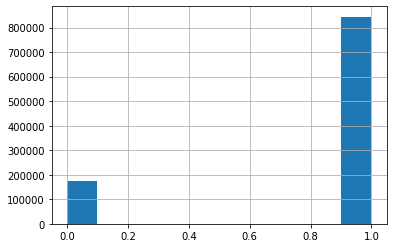

In [377]:
df_train.Open.hist()

In [378]:
store_open = df_train[df_train.Open==1]

In [379]:
df_train[df_train.Open==1]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,Day,Week,MonthYear,is_quarter_start,is_quarter_end,is_month_start,is_month_end,is_year_start,is_year_end,SalesbyCustomer
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,...,31,31,2015-07,0,0,0,1,0,0,9.482883
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,...,31,31,2015-07,0,0,0,1,0,0,9.702400
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,...,31,31,2015-07,0,0,0,1,0,0,10.126675
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,...,31,31,2015-07,0,0,0,1,0,0,9.342457
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,...,31,31,2015-07,0,0,0,1,0,0,8.626118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,1,0,1,1,2013,...,1,1,2013-01,1,0,1,0,1,0,5.962898
1016827,733,2,2013-01-01,10765,2377,1,0,1,1,2013,...,1,1,2013-01,1,0,1,0,1,0,4.528818
1016863,769,2,2013-01-01,5035,1248,1,0,1,1,2013,...,1,1,2013-01,1,0,1,0,1,0,4.034455
1017042,948,2,2013-01-01,4491,1039,1,0,1,1,2013,...,1,1,2013-01,1,0,1,0,1,0,4.322425


<AxesSubplot:xlabel='Open', ylabel='count'>

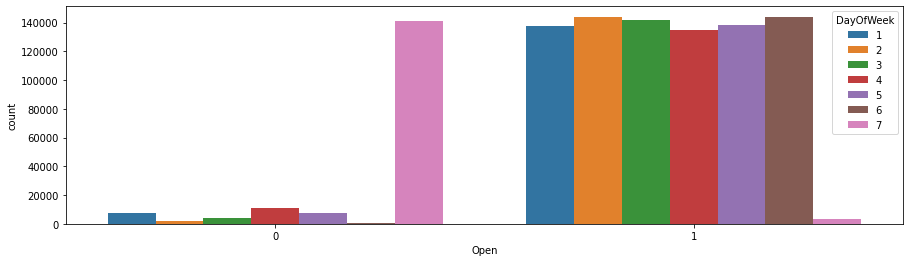

In [380]:
#  Let's plot the store by DayOfWeek and Open/Close
fig,(axis1) = plt.subplots(1,1,figsize=(15,4))
sns.countplot(x='Open',hue='DayOfWeek', data=df_train, ax=axis1)

In [381]:
# Let's check the stores that are closed on Sunday --> 141137
df_train.loc[(df_train.DayOfWeek==7) & (df_train.Open==0)]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,Day,Week,MonthYear,is_quarter_start,is_quarter_end,is_month_start,is_month_end,is_year_start,is_year_end,SalesbyCustomer
5575,1,7,2015-07-26,0,0,0,0,0,0,2015,...,26,30,2015-07,0,0,0,0,0,0,0.0
5576,2,7,2015-07-26,0,0,0,0,0,0,2015,...,26,30,2015-07,0,0,0,0,0,0,0.0
5577,3,7,2015-07-26,0,0,0,0,0,0,2015,...,26,30,2015-07,0,0,0,0,0,0,0.0
5578,4,7,2015-07-26,0,0,0,0,0,0,2015,...,26,30,2015-07,0,0,0,0,0,0,0.0
5579,5,7,2015-07-26,0,0,0,0,0,0,2015,...,26,30,2015-07,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1011630,1111,7,2013-01-06,0,0,0,0,0,0,2013,...,6,1,2013-01,0,0,0,0,0,0,0.0
1011631,1112,7,2013-01-06,0,0,0,0,0,0,2013,...,6,1,2013-01,0,0,0,0,0,0,0.0
1011632,1113,7,2013-01-06,0,0,0,0,0,0,2013,...,6,1,2013-01,0,0,0,0,0,0,0.0
1011633,1114,7,2013-01-06,0,0,0,0,0,0,2013,...,6,1,2013-01,0,0,0,0,0,0,0.0


In [382]:
df_train

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,Day,Week,MonthYear,is_quarter_start,is_quarter_end,is_month_start,is_month_end,is_year_start,is_year_end,SalesbyCustomer
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,...,31,31,2015-07,0,0,0,1,0,0,9.482883
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,...,31,31,2015-07,0,0,0,1,0,0,9.702400
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,...,31,31,2015-07,0,0,0,1,0,0,10.126675
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,...,31,31,2015-07,0,0,0,1,0,0,9.342457
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,...,31,31,2015-07,0,0,0,1,0,0,8.626118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,1,1,2013,...,1,1,2013-01,1,0,1,0,1,0,0.000000
1017205,1112,2,2013-01-01,0,0,0,0,1,1,2013,...,1,1,2013-01,1,0,1,0,1,0,0.000000
1017206,1113,2,2013-01-01,0,0,0,0,1,1,2013,...,1,1,2013-01,1,0,1,0,1,0,0.000000
1017207,1114,2,2013-01-01,0,0,0,0,1,1,2013,...,1,1,2013-01,1,0,1,0,1,0,0.000000


In [383]:
df_train.isnull().sum()

Store               0
DayOfWeek           0
Date                0
Sales               0
Customers           0
Open                0
Promo               0
StateHoliday        0
SchoolHoliday       0
Year                0
Month               0
Day                 0
Week                0
MonthYear           0
is_quarter_start    0
is_quarter_end      0
is_month_start      0
is_month_end        0
is_year_start       0
is_year_end         0
SalesbyCustomer     0
dtype: int64

In [384]:
# Let's augment with some data
#dt = datetime.datetime.today()
df_train['Year'] = df_train['Date'].dt.year
df_train['Month'] = df_train['Date'].dt.month
df_train['Day'] = df_train['Date'].dt.day
df_train['Week'] = df_train['Date'].dt.isocalendar().week
df_train['MonthYear'] = df_train['Date'].apply(lambda x: (str(x)[:7]))
df_train['is_quarter_start'] = df_train['Date'].dt.is_quarter_start
df_train['is_quarter_end'] = df_train['Date'].dt.is_quarter_end
df_train['is_month_start'] = df_train['Date'].dt.is_month_start
df_train['is_month_end'] = df_train['Date'].dt.is_month_end
df_train['is_year_start'] = df_train['Date'].dt.is_year_start
df_train['is_year_end'] = df_train['Date'].dt.is_year_end

# Let's do the same for the test set
df_test['Year'] = df_test['Date'].dt.year
df_test['Month'] = df_test['Date'].dt.month
df_test['Day'] = df_test['Date'].dt.day
df_test['Week'] = df_test['Date'].dt.isocalendar().week
df_test['MonthYear'] = df_test['Date'].apply(lambda x: (str(x)[:7]))
df_test['is_quarter_start'] = df_test['Date'].dt.is_quarter_start
df_test['is_quarter_end'] = df_test['Date'].dt.is_quarter_end
df_test['is_month_start'] = df_test['Date'].dt.is_month_start
df_test['is_month_end'] = df_test['Date'].dt.is_month_end
df_test['is_year_start'] = df_test['Date'].dt.is_year_start
df_test['is_year_end'] = df_test['Date'].dt.is_year_end

In [385]:
df_train.is_quarter_start=df_train.is_quarter_start.apply(lambda x: 0 if x==False else 1)
df_train.is_quarter_end=df_train.is_quarter_end.apply(lambda x: 0 if x==False else 1)
df_train.is_month_start=df_train.is_month_start.apply(lambda x: 0 if x==False else 1)
df_train.is_month_end=df_train.is_month_end.apply(lambda x: 0 if x==False else 1)
df_train.is_year_start=df_train.is_year_start.apply(lambda x: 0 if x==False else 1)
df_train.is_year_end=df_train.is_year_end.apply(lambda x: 0 if x==False else 1)

df_test.is_quarter_start=df_test.is_quarter_start.apply(lambda x: 0 if x==False else 1)
df_test.is_quarter_end=df_test.is_quarter_end.apply(lambda x: 0 if x==False else 1)
df_test.is_month_start=df_test.is_month_start.apply(lambda x: 0 if x==False else 1)
df_test.is_month_end=df_test.is_month_end.apply(lambda x: 0 if x==False else 1)
df_test.is_year_start=df_test.is_year_start.apply(lambda x: 0 if x==False else 1)
df_test.is_year_end=df_test.is_year_end.apply(lambda x: 0 if x==False else 1)

In [280]:
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,Week,MonthYear,is_quarter_start,is_quarter_end,is_month_start,is_month_end,is_year_start,is_year_end
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,31,31,2015-07,0,0,0,1,0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7,31,31,2015-07,0,0,0,1,0,0
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7,31,31,2015-07,0,0,0,1,0,0
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,7,31,31,2015-07,0,0,0,1,0,0
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,7,31,31,2015-07,0,0,0,1,0,0


In [281]:
# Let's remember the null values
df_train.isnull().sum()

Store               0
DayOfWeek           0
Date                0
Sales               0
Customers           0
Open                0
Promo               0
StateHoliday        0
SchoolHoliday       0
Year                0
Month               0
Day                 0
Week                0
MonthYear           0
is_quarter_start    0
is_quarter_end      0
is_month_start      0
is_month_end        0
is_year_start       0
is_year_end         0
dtype: int64

In [386]:
# Let's see the store closed (not open, this is Open=0) --Z there are 172817 almost all the null values
len(df_train[df_train.Open==0])

172817

In [387]:
# Let's augment with some more data
df_train['SalesbyCustomer']= df_train['Sales']/df_train['Customers']

In [388]:
# Let's see how much spend customers a day: A mean of almost 10 euros
df_train.SalesbyCustomer.describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalesbyCustomer, dtype: float64

<AxesSubplot:>

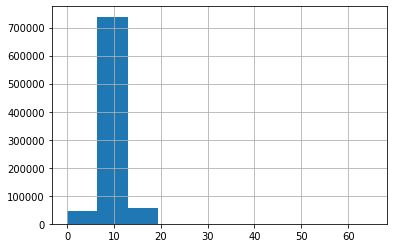

In [389]:
df_train.SalesbyCustomer.hist()

In [390]:
# There 4 types of holidays, but we are interested only if a day is holiday or not
# So we change the values into 0/1
df_train.StateHoliday=df_train.StateHoliday.apply(lambda x: 0 if x==0 or x=='0' else 1)

In [391]:
# Let's remember the null values
df_train.isnull().sum()

Store                    0
DayOfWeek                0
Date                     0
Sales                    0
Customers                0
Open                     0
Promo                    0
StateHoliday             0
SchoolHoliday            0
Year                     0
Month                    0
Day                      0
Week                     0
MonthYear                0
is_quarter_start         0
is_quarter_end           0
is_month_start           0
is_month_end             0
is_year_start            0
is_year_end              0
SalesbyCustomer     172869
dtype: int64

In [392]:
# If the store is close there will be no sales (SalesbyCustomer=0)
# so we can impute these Nans with 0
df_train['SalesbyCustomer'][df_train.Open==0]=0

In [393]:
df_test.isnull().sum()

Id                  0
Store               0
DayOfWeek           0
Date                0
Open                0
Promo               0
StateHoliday        0
SchoolHoliday       0
Year                0
Month               0
Day                 0
Week                0
MonthYear           0
is_quarter_start    0
is_quarter_end      0
is_month_start      0
is_month_end        0
is_year_start       0
is_year_end         0
dtype: int64

In [394]:
df_test[df_test.Open==0]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,Week,MonthYear,is_quarter_start,is_quarter_end,is_month_start,is_month_end,is_year_start,is_year_end
543,544,703,4,2015-09-17,0.0,1,0,0,2015,9,17,38,2015-09,0,0,0,0,0,0
676,677,879,4,2015-09-17,0.0,1,0,0,2015,9,17,38,2015-09,0,0,0,0,0,0
840,841,1097,4,2015-09-17,0.0,1,0,0,2015,9,17,38,2015-09,0,0,0,0,0,0
1399,1400,703,3,2015-09-16,0.0,1,0,0,2015,9,16,38,2015-09,0,0,0,0,0,0
1532,1533,879,3,2015-09-16,0.0,1,0,0,2015,9,16,38,2015-09,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40227,40228,1111,7,2015-08-02,0.0,0,0,0,2015,8,2,31,2015-08,0,0,0,0,0,0
40228,40229,1112,7,2015-08-02,0.0,0,0,0,2015,8,2,31,2015-08,0,0,0,0,0,0
40229,40230,1113,7,2015-08-02,0.0,0,0,0,2015,8,2,31,2015-08,0,0,0,0,0,0
40230,40231,1114,7,2015-08-02,0.0,0,0,0,2015,8,2,31,2015-08,0,0,0,0,0,0


In [395]:
# If there is no Sales, then SalesbyCustomer=0
df_train['SalesbyCustomer'][df_train.Sales==0]=0

In [396]:
# Let's remember the null values
df_train.isnull().sum()

Store               0
DayOfWeek           0
Date                0
Sales               0
Customers           0
Open                0
Promo               0
StateHoliday        0
SchoolHoliday       0
Year                0
Month               0
Day                 0
Week                0
MonthYear           0
is_quarter_start    0
is_quarter_end      0
is_month_start      0
is_month_end        0
is_year_start       0
is_year_end         0
SalesbyCustomer     0
dtype: int64

In [397]:
# Let's merge df_store and df_train on Store
df_train_store = pd.merge(df_train, df_store, how = 'inner', on = 'Store')

In [398]:
df_train_store.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,SalesbyCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,...,9.482883,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,2015,...,9.194139,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,2015,...,9.143403,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,2015,...,8.948214,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,2015,...,9.970588,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0


In [399]:
df_train_store.isnull().sum()

Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
Year                         0
Month                        0
Day                          0
Week                         0
MonthYear                    0
is_quarter_start             0
is_quarter_end               0
is_month_start               0
is_month_end                 0
is_year_start                0
is_year_end                  0
SalesbyCustomer              0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [400]:
df_train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
1,551627.0,5738.179710,3964.028134,0.0,3508.0,5618.0,7860.00,41551.0
2,15830.0,10058.837334,5280.525506,0.0,6227.0,9025.5,13082.75,38722.0
3,136840.0,5723.629246,3721.700886,0.0,3789.0,5766.0,7849.00,31448.0
4,312912.0,5641.819243,3473.393781,0.0,3986.0,5826.0,7691.00,38037.0


Now we can play with the data! Let's try to answer some questions

1. How much is the average sales by Month and Year?

In [401]:
# Let's prepare a dataframe containing the Sales by Month & Year
average_sales = df_train.groupby('MonthYear')["Sales"].mean()

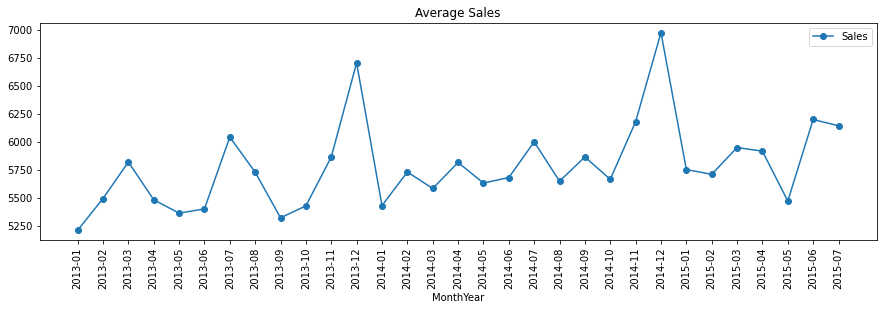

In [402]:
#  Let's plot the average sales by Month & Year
fig,(axis1) = plt.subplots(1,1,figsize=(15,4))
ax1 = average_sales.plot(legend=True,ax=axis1,marker='o',title="Average Sales")
ax1.set_xticks(range(len(average_sales)))
ax1.set_xticklabels(average_sales.index.tolist(), rotation=90);

2. How much are the sales by Year?

In [403]:
# Let's prepare a dataframe containing the Sales by Year
yearly_sales = df_train.groupby('Year')["Sales"].sum()

In [404]:
yearly_sales 

Year
2013    2302876084
2014    2180804896
2015    1389499643
Name: Sales, dtype: int64

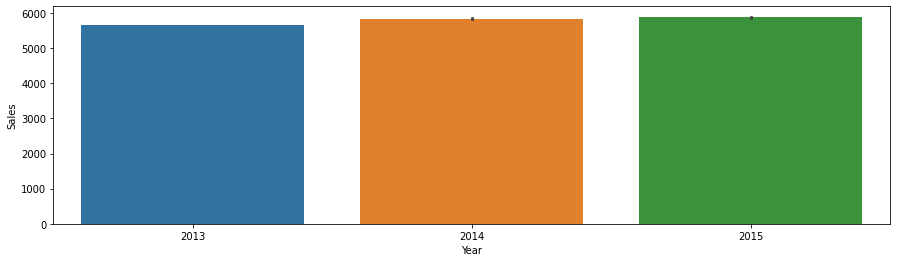

In [405]:
#  Let's plot sales by Year
fig,(axis1) = plt.subplots(1,1,figsize=(15,4))
sns.barplot(x='Year', y='Sales', data=df_train, ax=axis1);

3. How many customers do we have by Year?

In [406]:
# Let's prepare a dataframe containing the Customers by Month & Year
average_customers = df_train.groupby('MonthYear')["Customers"].mean()

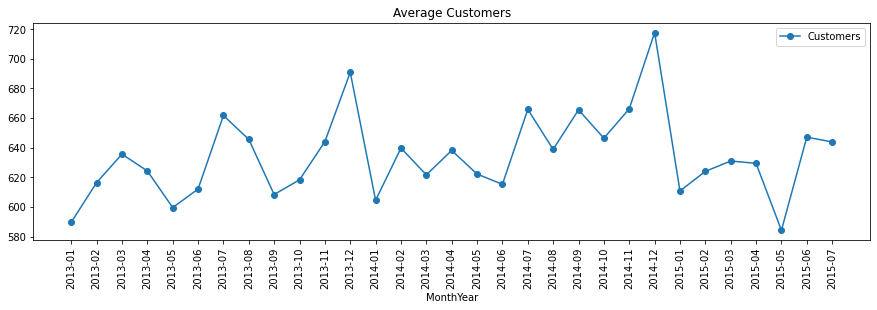

In [407]:
#  Let's plot the average customers by Month & Year
fig,(axis1) = plt.subplots(1,1,figsize=(15,4))
ax1 = average_customers.plot(legend=True,ax=axis1,marker='o',title="Average Customers")
ax1.set_xticks(range(len(average_customers)))
ax1.set_xticklabels(average_customers.index.tolist(), rotation=90);

4. Is there a day of the week with more customers?



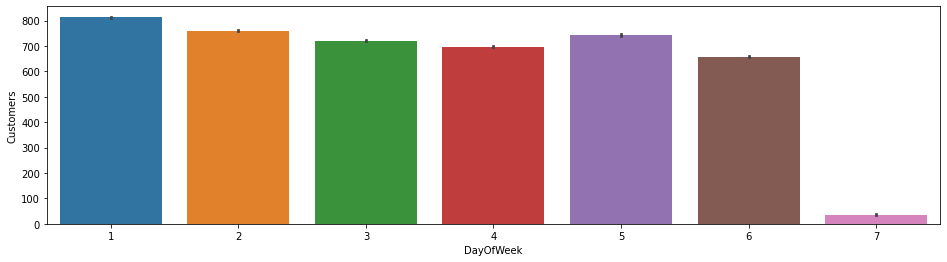

In [306]:
#  Let's plot customers by day of week
fig,(axis1) = plt.subplots(1,1,figsize=(16,4))
sns.barplot(x='DayOfWeek', y='Customers', data=df_train, order=[1,2,3,4,5,6,7], ax=axis1);

It seems that Mondays and Fridays are the most visited days

5. Is there a day of the week with more Sales?

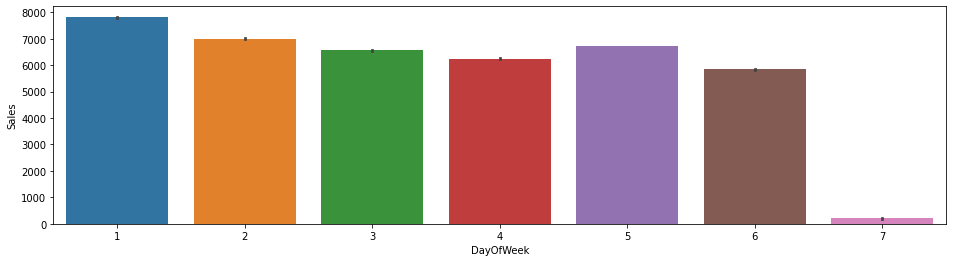

In [307]:
#  Let's plot sales by day of week
fig,(axis1) = plt.subplots(1,1,figsize=(16,4))
sns.barplot(x='DayOfWeek', y='Sales', data=df_train, order=[1,2,3,4,5,6,7], ax=axis1);

It seems that also Mondays and Fridays are the best days for income!

Does the promos influence on sales or customers?

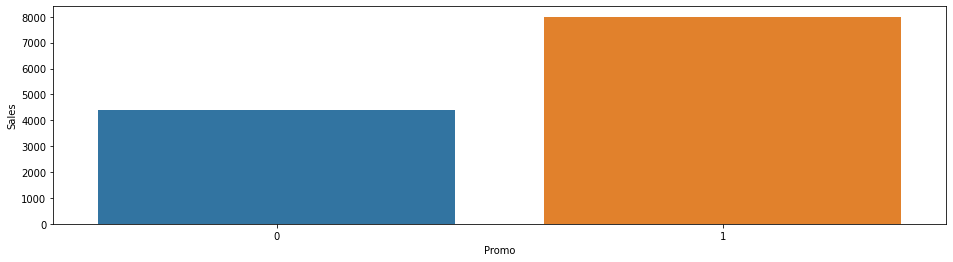

In [308]:
#  Let's plot promo by Sales
fig,(axis1) = plt.subplots(1,1,figsize=(16,4))
sns.barplot(x='Promo', y='Sales', data=df_train, ax=axis1);

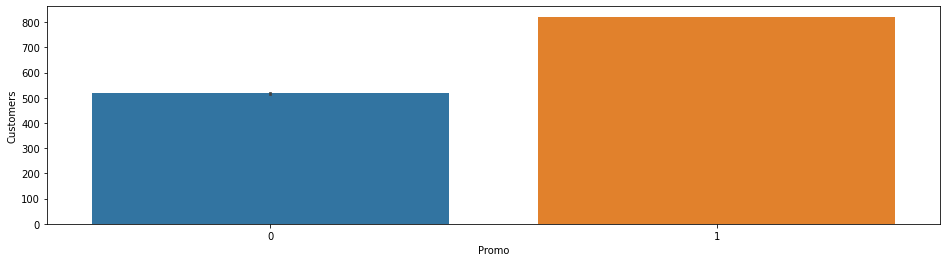

In [309]:
#  Let's plot Promo by Customers
fig,(axis1) = plt.subplots(1,1,figsize=(16,4))
sns.barplot(x='Promo', y='Customers', data=df_train, ax=axis1);

It's clear that when there is a Promo, sales and visits increase

What is the shop that has more Sales/Customers?

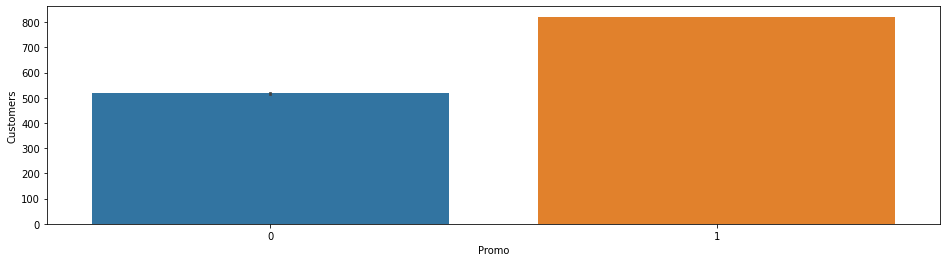

In [310]:
fig,(axis1) = plt.subplots(1,1,figsize=(16,4))
sns.barplot(x='Promo', y='Customers', data=df_train, ax=axis1);

In [311]:
customers_shop = df_train.groupby('Store')["Customers"].mean()

In [312]:
customers_shop

Store
1        467.646497
2        486.045648
3        620.286624
4       1100.057325
5        444.360934
           ...     
1111     373.548832
1112     693.498938
1113     596.763270
1114    2664.057325
1115     358.687898
Name: Customers, Length: 1115, dtype: float64

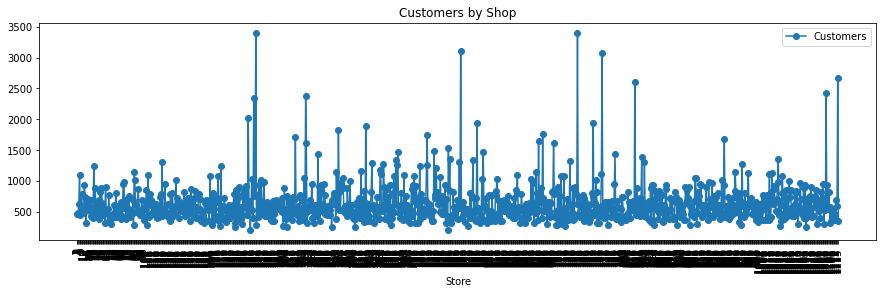

In [313]:
#  Let's plot the average customers by Month & Year
fig,(axis1) = plt.subplots(1,1,figsize=(15,4))
ax1 = customers_shop.plot(legend=True,ax=axis1,marker='o',title="Customers by Shop")
ax1.set_xticks(range(len(customers_shop)))
ax1.set_xticklabels(customers_shop.index.tolist(), rotation=90);

In [314]:
df_corr = df_train.corr()

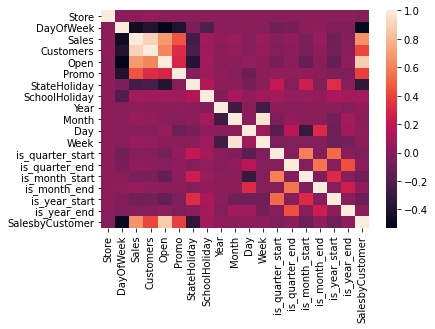

In [315]:
sns.heatmap(df_corr);

# let's analyse the test dataset

In [323]:
# There are 41088 rows and 8 columns on df_test dataset
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Id                41088 non-null  int64         
 1   Store             41088 non-null  int64         
 2   DayOfWeek         41088 non-null  int64         
 3   Date              41088 non-null  datetime64[ns]
 4   Open              41088 non-null  float64       
 5   Promo             41088 non-null  int64         
 6   StateHoliday      41088 non-null  object        
 7   SchoolHoliday     41088 non-null  int64         
 8   Year              41088 non-null  int64         
 9   Month             41088 non-null  int64         
 10  Day               41088 non-null  int64         
 11  Week              41088 non-null  UInt32        
 12  MonthYear         41088 non-null  object        
 13  is_quarter_start  41088 non-null  bool          
 14  is_quarter_end    4108

In [324]:
# There are 41088 rows and 6 columns on df_shops dataset
df_test.describe()

,Id,Store,DayOfWeek,Open,Promo,SchoolHoliday,Year,Month,Day,Week
count,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.0,41088.000000,41088.000000,41088.000000
mean,20544.500000,555.899533,3.979167,0.854361,0.395833,0.443487,2015.0,8.354167,13.520833,34.645833
std,11861.228267,320.274496,2.015481,0.352748,0.489035,0.496802,0.0,0.478266,8.448450,2.015481
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2015.0,8.000000,1.000000,31.000000
25%,10272.750000,279.750000,2.000000,1.000000,0.000000,0.000000,2015.0,8.000000,6.750000,33.000000
50%,20544.500000,553.500000,4.000000,1.000000,0.000000,0.000000,2015.0,8.000000,12.500000,35.000000
75%,30816.250000,832.250000,6.000000,1.000000,1.000000,1.000000,2015.0,9.000000,19.250000,36.000000
max,41088.000000,1115.000000,7.000000,1.000000,1.000000,1.000000,2015.0,9.000000,31.000000,38.000000


In [325]:
# There are 1115 rows and 10 columns on df_store dataset
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Id                41088 non-null  int64         
 1   Store             41088 non-null  int64         
 2   DayOfWeek         41088 non-null  int64         
 3   Date              41088 non-null  datetime64[ns]
 4   Open              41088 non-null  float64       
 5   Promo             41088 non-null  int64         
 6   StateHoliday      41088 non-null  object        
 7   SchoolHoliday     41088 non-null  int64         
 8   Year              41088 non-null  int64         
 9   Month             41088 non-null  int64         
 10  Day               41088 non-null  int64         
 11  Week              41088 non-null  UInt32        
 12  MonthYear         41088 non-null  object        
 13  is_quarter_start  41088 non-null  bool          
 14  is_quarter_end    4108

In [326]:
df_test.isnull().sum()

Id                  0
Store               0
DayOfWeek           0
Date                0
Open                0
Promo               0
StateHoliday        0
SchoolHoliday       0
Year                0
Month               0
Day                 0
Week                0
MonthYear           0
is_quarter_start    0
is_quarter_end      0
is_month_start      0
is_month_end        0
is_year_start       0
is_year_end         0
dtype: int64

In [327]:
df_test[df_test.Open.isnull()]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,Week,MonthYear,is_quarter_start,is_quarter_end,is_month_start,is_month_end,is_year_start,is_year_end


In [328]:
# Let's eliminate the null values of Open field
df_test.loc[df_test.Open.isnull(),'Open']=1

In [329]:
df_test.isnull().sum()

Id                  0
Store               0
DayOfWeek           0
Date                0
Open                0
Promo               0
StateHoliday        0
SchoolHoliday       0
Year                0
Month               0
Day                 0
Week                0
MonthYear           0
is_quarter_start    0
is_quarter_end      0
is_month_start      0
is_month_end        0
is_year_start       0
is_year_end         0
dtype: int64

In [330]:
# df_test goes from 01-08-2015 until 17-09-2015
df_test.Date.min()
df_test.Date.max()

Timestamp('2015-09-17 00:00:00')

In [331]:
subset = df_train[(df_train['Store'] == 622)  & (df_train['Date'].isin(df_test[df_test.Open.isnull()].Date))]

In [332]:
df_train[(df_train['Store'] == 622) & (df_train.Month==7) & (df_train.Year==2015)]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,Day,Week,MonthYear,is_quarter_start,is_quarter_end,is_month_start,is_month_end,is_year_start,is_year_end,SalesbyCustomer
621,622,5,2015-07-31,6306,540,1,1,0,1,2015,...,31,31,2015-07,0,0,0,1,0,0,11.677778
1736,622,4,2015-07-30,5412,406,1,1,0,1,2015,...,30,31,2015-07,0,0,0,0,0,0,13.330049
2851,622,3,2015-07-29,5326,468,1,1,0,1,2015,...,29,31,2015-07,0,0,0,0,0,0,11.380342
3966,622,2,2015-07-28,4966,417,1,1,0,1,2015,...,28,31,2015-07,0,0,0,0,0,0,11.908873
5081,622,1,2015-07-27,5413,517,1,1,0,1,2015,...,27,31,2015-07,0,0,0,0,0,0,10.470019
6196,622,7,2015-07-26,0,0,0,0,0,0,2015,...,26,30,2015-07,0,0,0,0,0,0,0.000000
7311,622,6,2015-07-25,2644,257,1,0,0,0,2015,...,25,30,2015-07,0,0,0,0,0,0,10.287938
8426,622,5,2015-07-24,4183,440,1,0,0,1,2015,...,24,30,2015-07,0,0,0,0,0,0,9.506818
9541,622,4,2015-07-23,3970,399,1,0,0,1,2015,...,23,30,2015-07,0,0,0,0,0,0,9.949875
10656,622,3,2015-07-22,3721,376,1,0,0,1,2015,...,22,30,2015-07,0,0,0,0,0,0,9.896277


In [333]:
df_train[(df_train['Store'] == 622)]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,Day,Week,MonthYear,is_quarter_start,is_quarter_end,is_month_start,is_month_end,is_year_start,is_year_end,SalesbyCustomer
621,622,5,2015-07-31,6306,540,1,1,0,1,2015,...,31,31,2015-07,0,0,0,1,0,0,11.677778
1736,622,4,2015-07-30,5412,406,1,1,0,1,2015,...,30,31,2015-07,0,0,0,0,0,0,13.330049
2851,622,3,2015-07-29,5326,468,1,1,0,1,2015,...,29,31,2015-07,0,0,0,0,0,0,11.380342
3966,622,2,2015-07-28,4966,417,1,1,0,1,2015,...,28,31,2015-07,0,0,0,0,0,0,11.908873
5081,622,1,2015-07-27,5413,517,1,1,0,1,2015,...,27,31,2015-07,0,0,0,0,0,0,10.470019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1012256,622,6,2013-01-05,2350,258,1,0,0,0,2013,...,5,1,2013-01,0,0,0,0,0,0,9.108527
1013371,622,5,2013-01-04,3675,399,1,0,0,1,2013,...,4,1,2013-01,0,0,0,0,0,0,9.210526
1014486,622,4,2013-01-03,4085,419,1,0,0,1,2013,...,3,1,2013-01,0,0,0,0,0,0,9.749403
1015601,622,3,2013-01-02,4080,451,1,0,0,1,2013,...,2,1,2013-01,0,0,0,0,0,0,9.046563


In [334]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 21 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Store             1017209 non-null  int64         
 1   DayOfWeek         1017209 non-null  int64         
 2   Date              1017209 non-null  datetime64[ns]
 3   Sales             1017209 non-null  int64         
 4   Customers         1017209 non-null  int64         
 5   Open              1017209 non-null  int64         
 6   Promo             1017209 non-null  int64         
 7   StateHoliday      1017209 non-null  int64         
 8   SchoolHoliday     1017209 non-null  int64         
 9   Year              1017209 non-null  int64         
 10  Month             1017209 non-null  int64         
 11  Day               1017209 non-null  int64         
 12  Week              1017209 non-null  UInt32        
 13  MonthYear         1017209 non-null  object

In [335]:
df_corr_test = df_test.corr()

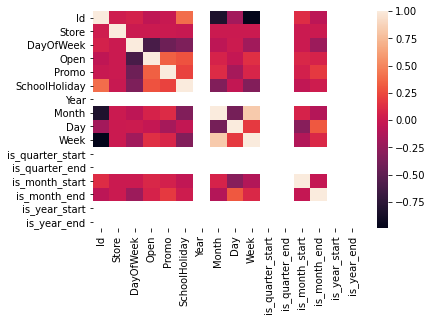

In [336]:
sns.heatmap(df_corr_test);

In [337]:
df_train.StateHoliday.unique()

array([0, 1], dtype=int64)

In [338]:
df_train.StateHoliday=df_train.StateHoliday.apply(lambda x: 0 if x==0 or x=='0' else 1)

In [339]:
df_train.StateHoliday.unique()

array([0, 1], dtype=int64)

In [340]:
df_train.SchoolHoliday.unique()

array([1, 0], dtype=int64)

In [343]:
df_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,Week,MonthYear,is_quarter_start,is_quarter_end,is_month_start,is_month_end,is_year_start,is_year_end
0,1,1,4,2015-09-17,1.0,1,0,0,2015,9,17,38,2015-09,0,0,0,0,0,0
1,2,3,4,2015-09-17,1.0,1,0,0,2015,9,17,38,2015-09,0,0,0,0,0,0
2,3,7,4,2015-09-17,1.0,1,0,0,2015,9,17,38,2015-09,0,0,0,0,0,0
3,4,8,4,2015-09-17,1.0,1,0,0,2015,9,17,38,2015-09,0,0,0,0,0,0
4,5,9,4,2015-09-17,1.0,1,0,0,2015,9,17,38,2015-09,0,0,0,0,0,0


In [344]:
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,Day,Week,MonthYear,is_quarter_start,is_quarter_end,is_month_start,is_month_end,is_year_start,is_year_end,SalesbyCustomer
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,...,31,31,2015-07,0,0,0,1,0,0,9.482883
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,...,31,31,2015-07,0,0,0,1,0,0,9.702400
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,...,31,31,2015-07,0,0,0,1,0,0,10.126675
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,...,31,31,2015-07,0,0,0,1,0,0,9.342457
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,...,31,31,2015-07,0,0,0,1,0,0,8.626118


In [354]:
df_train_store.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,is_month_end,is_year_start,is_year_end,SalesbyCustomer,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,...,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,3.052470e-02,1.786467e-01,2.013832e+03,5.846762e+00,...,3.291851e-02,3.287427e-03,2.015318e-03,7.880231e+00,5.422021e+03,4.926878e+00,1.370173e+03,5.005638e-01,1.164767e+01,1.007011e+03
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,1.720261e-01,3.830564e-01,7.773960e-01,3.326097e+00,...,1.784234e-01,5.724179e-02,4.484706e-02,4.089279e+00,7.706918e+03,4.283543e+00,9.353634e+02,4.999999e-01,1.532393e+01,1.005877e+03
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.013000e+03,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.013000e+03,3.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,6.905375e+00,7.100000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.014000e+03,6.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,8.683684e+00,2.325000e+03,4.000000e+00,2.006000e+03,1.000000e+00,1.000000e+00,2.009000e+03
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.014000e+03,8.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,1.051098e+01,6.880000e+03,9.000000e+00,2.011000e+03,1.000000e+00,2.200000e+01,2.012000e+03
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.015000e+03,1.200000e+01,...,1.000000e+00,1.000000e+00,1.000000e+00,6.495785e+01,7.586000e+04,1.200000e+01,2.015000e+03,1.000000e+00,5.000000e+01,2.015000e+03


In [410]:
df_train_store.head(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,SalesbyCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,...,9.482883,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,2015,...,9.194139,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,2015,...,9.143403,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0


In [351]:
df_train_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 30 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  int64         
 8   SchoolHoliday              1017209 non-null  int64         
 9   Year                       1017209 non-null  int64         
 10  Month                      1017209 non-null  int64         
 11  Day                        1017209 no

In [408]:
# Now let's start with the Feature Engineering
#features = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday',\
#            'Year', 'Month','Day','Week','StoreType', 'Assortment', 'CompetitionDistance',
#       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
#       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval','Sales']  

In [415]:
# Now let's start with the Feature Engineering
features = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday',\
            'Year', 'Month','Day','Week','StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'Sales']  

In [416]:
train = df_train_store[features]

In [417]:
train.head(5)

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,Week,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Sales
0,1,5,1,0,1,2015,7,31,31,3,1,1270.0,9.0,2008.0,0,0.0,0.0,5263
1,1,4,1,0,1,2015,7,30,31,3,1,1270.0,9.0,2008.0,0,0.0,0.0,5020
2,1,3,1,0,1,2015,7,29,31,3,1,1270.0,9.0,2008.0,0,0.0,0.0,4782
3,1,2,1,0,1,2015,7,28,31,3,1,1270.0,9.0,2008.0,0,0.0,0.0,5011
4,1,1,1,0,1,2015,7,27,31,3,1,1270.0,9.0,2008.0,0,0.0,0.0,6102


In [418]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Promo                      1017209 non-null  int64  
 3   StateHoliday               1017209 non-null  int64  
 4   SchoolHoliday              1017209 non-null  int64  
 5   Year                       1017209 non-null  int64  
 6   Month                      1017209 non-null  int64  
 7   Day                        1017209 non-null  int64  
 8   Week                       1017209 non-null  UInt32 
 9   StoreType                  1017209 non-null  int64  
 10  Assortment                 1017209 non-null  int64  
 11  CompetitionDistance        1017209 non-null  float64
 12  CompetitionOpenSinceMonth  1017209 non-null  float64
 13  CompetitionO

In [419]:
train.PromoInterval

AttributeError: 'DataFrame' object has no attribute 'PromoInterval'

In [421]:
# define standard scaler
scaler = StandardScaler()
# transform data
scaled = scaler.fit_transform(train)

In [426]:
# split x and y
X, y = train.drop(columns = ['Sales']), np.log1p(train['Sales'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.60, random_state=42)

In [432]:
X_train

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,Week,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
796925,874,2,0,0,0,2013,3,12,11,1,1,3210.0,0.0,0.0,0,0.0,0.0
77479,85,4,1,0,1,2013,7,18,29,2,1,1870.0,10.0,2011.0,0,0.0,0.0
716482,787,4,1,0,1,2014,8,7,32,3,3,3210.0,6.0,2009.0,0,0.0,0.0
373868,410,3,1,0,1,2014,7,30,31,3,1,40.0,11.0,2011.0,1,22.0,2012.0
585902,643,7,0,0,0,2013,10,27,43,1,1,230.0,6.0,2010.0,1,18.0,2010.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,286,2,0,0,0,2014,10,28,44,1,1,1460.0,4.0,2015.0,0,0.0,0.0
365838,401,5,1,0,0,2013,11,8,45,1,3,9200.0,10.0,2009.0,1,14.0,2012.0
131932,146,3,0,0,0,2014,9,24,39,4,3,8050.0,10.0,1961.0,1,48.0,2012.0
671155,737,2,1,0,0,2013,4,9,15,1,1,100.0,5.0,2007.0,1,31.0,2013.0


In [427]:
# define eval metrics
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

In [429]:
# try random forest
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(n_estimators = 15)
clf.fit(X_train, y_train)
# validation
y_pred = clf.predict(X_test)
error = rmspe(np.expm1(y_test), np.expm1(y_pred))
print('RMSPE: {:.4f}'.format(error))

RMSPE: inf
